<a href="https://colab.research.google.com/github/chibuzorc/data_analysis/blob/main/IT7103_Team_2_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IT7103 Group 2 Team Members:**
*   **James Hodgson**
*   **Chibuzor Chukwu**
*   **Esther Uzoka**



# **Regression Modelling for Health Insurance Predictions**
### The goal of our project is to provide a model for insurance companies to predict health insurance premium to charge clients based on a set of features. This will allow companies to automate the underwriting process.


<br>


### **Kaggle Dataset: [here](https://raw.githubusercontent.com/jamesh9595/excel/main/insurance.csv)**

**Column Descriptions:**

* age: age of client

* sex: male or female

* bmi: body mass index of client

* children: the number of children of the client

* smokers: is the client a smoker, yes or no

* region: the client's residential area in the US, northeast, southeast, southwest, northwest

* charges: individual medical costs billed by health insurance.

<br>

# **Section 1: Loading and EDA**
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [ ]:
# Function to return regression model performance metrics

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def measures(model, modelName, actual, prediction):

  pred = model.predict(prediction)
  MAE = mean_absolute_error(actual, pred)
  MSE = mean_squared_error(actual, pred)
  r2 = r2_score(actual, pred)

  # Print Output
  print(modelName, '\n')
  print("MAE:", MAE)
  print("MSE:", MSE)
  print('r2 Score:', r2)
  print()

In [ ]:
# Function to plot predicted v actual target values

def plotPred(actual, predicted, model):
  plt.plot(actual, predicted, '.')
  plt.xlabel('Actual', fontsize=12)  # set x-axis label
  plt.ylabel('Predicted', fontsize=12)  # set y-axis label
  axes = plt.gca()
  plt.plot(axes.get_xlim(), axes.get_xlim(), '--')
  plt.title(model, fontsize=15)
  plt.show()

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/jamesh9595/excel/main/insurance.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## **No Null Values in dataset**

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# List of regions column value counts grouped by value

df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [ ]:
# comvert yes smoker to 1, no smoker to 0
df['smoker'] = df['smoker'].replace('yes', 1)
df['smoker'] = df['smoker'].replace('no', 0)

In [ ]:
from sklearn.model_selection import train_test_split

traindata, testdata = train_test_split(df, test_size=0.25, random_state=42)

In [ ]:
# collect number value columns

num_cols = [column for column in df.columns if (df[column].dtypes == np.int64) or (df[column].dtypes == np.float64)]

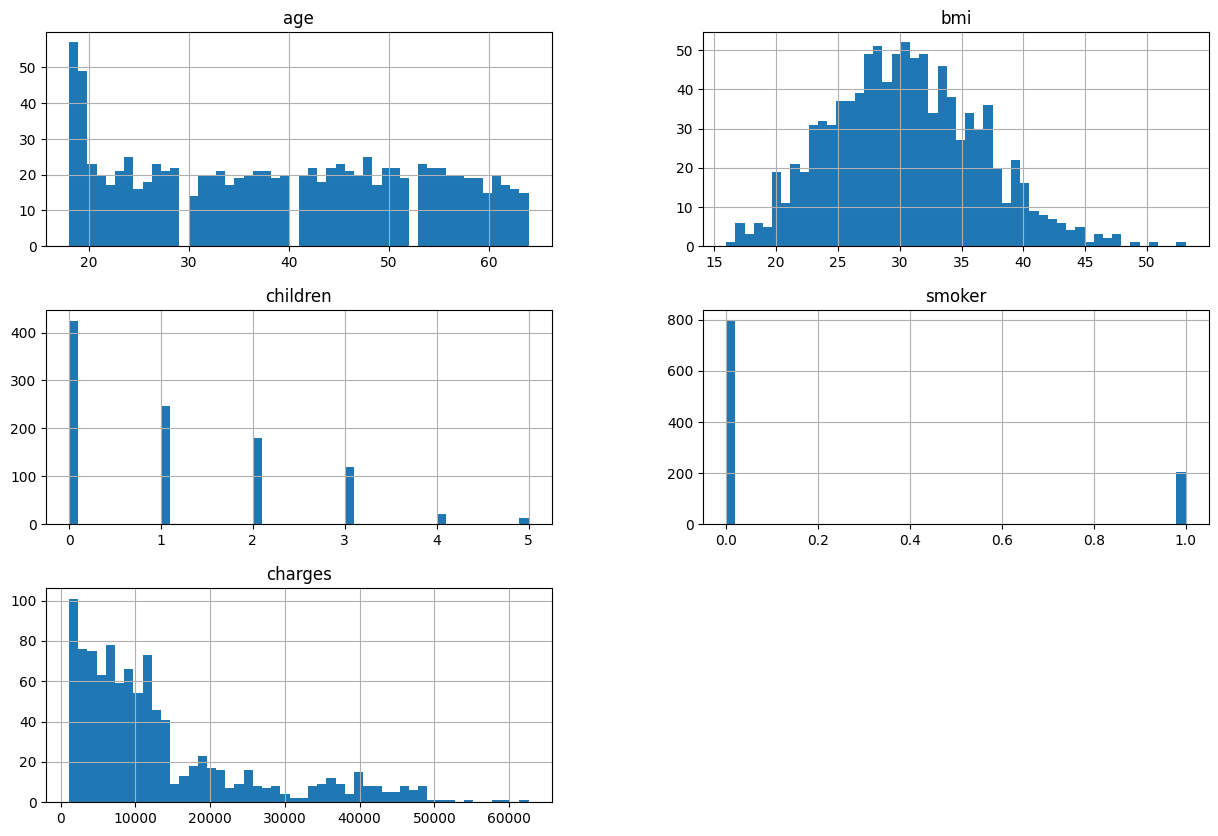

In [ ]:
import matplotlib.pyplot as plt

traindata.hist(bins=50, figsize=(15,10))
plt.show()

# **Only skewed column is charges, which is the target**

In [ ]:
num_cols = ['age', 'bmi', 'children', 'smoker']
cat_cols = ['sex', 'region' ]
target = 'charges'

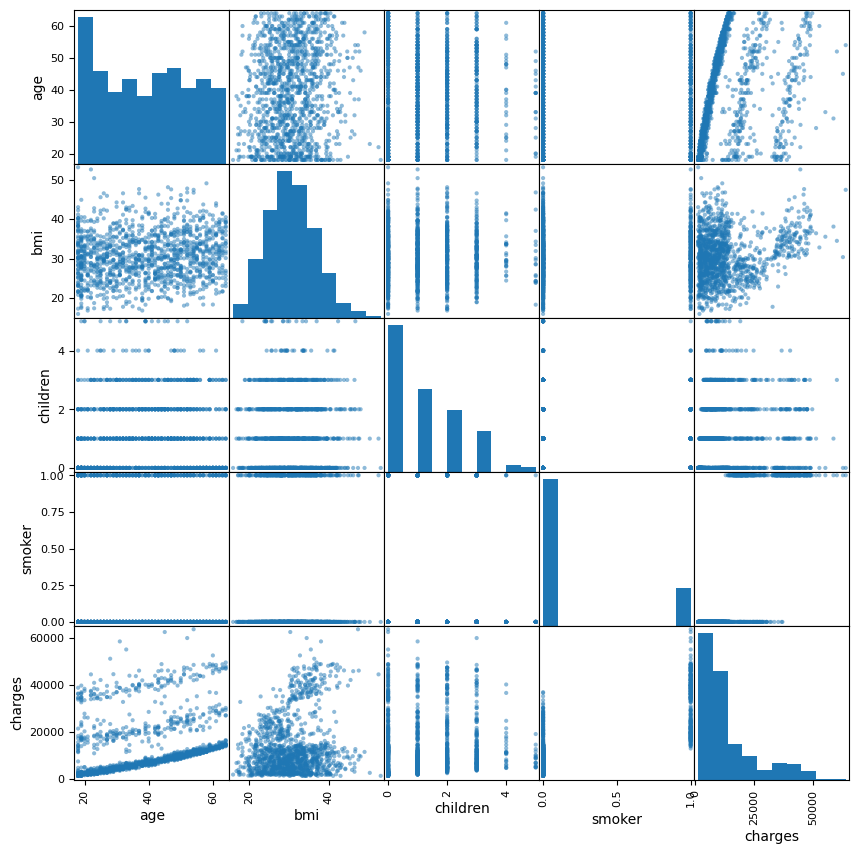

In [ ]:
pd.plotting.scatter_matrix(df[num_cols+[target]], figsize=(10,10))
plt.show()

<Axes: >

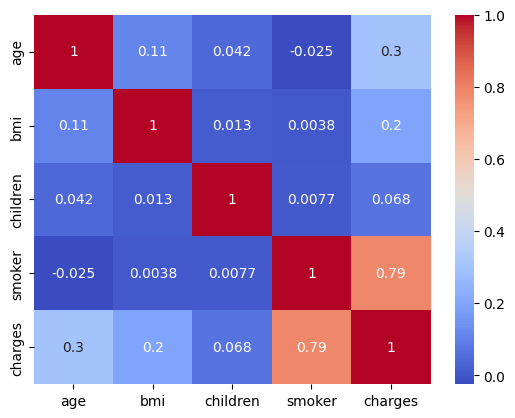

In [ ]:
import seaborn as sb
corr = df[num_cols+[target]].corr()
sb.heatmap(corr, cmap='coolwarm', annot=True)

# **Section 2: Regression Modeling**
---
<br>

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

#processing pipeline
#pipeline for numeric columns
num_pipeline = Pipeline([
    ('standardize', StandardScaler()),
    ('polynomial', PolynomialFeatures())
])

#pipline for Categorical columns
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(max_categories=5, handle_unknown='infrequent_if_exist'))
])

#final pipline merging all smaller pipelines through ColumnTransformer
full_pipeline = ColumnTransformer([
    ('Numeric', num_pipeline, num_cols),               #numeric columns
    ('Class', cat_pipeline, cat_cols)                  #class columns
])

# **Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge

ridgeReg = Pipeline([
    ('processing', full_pipeline),
    ('model', Ridge())
])
#ridgeReg.fit(traindata, traindata[target])

In [ ]:
from sklearn.model_selection import GridSearchCV

#hyperparameter search to tune model

param_grid = [{ #dictionary named param_grid containing list of dictionaries
    'processing__Numeric__polynomial__degree': [1,2,3,4],
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}]

ridge_grid = GridSearchCV(ridgeReg, param_grid, cv=5, scoring='r2', return_train_score=True)

ridge_grid.fit(traindata, traindata[target])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('processing',
                                        ColumnTransformer(transformers=[('Numeric',
                                                                         Pipeline(steps=[('standardize',
                                                                                          StandardScaler()),
                                                                                         ('polynomial',
                                                                                          PolynomialFeatures())]),
                                                                         ['age',
                                                                          'bmi',
                                                                          'children',
                                                                          'smoker']),
                                                                        ('Class',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                        max_categories=5))]),
                                                                         ['sex',
                                                                          'region'])])),
                                       ('model', Ridge())]),
             param_grid=[{'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                          'processing__Numeric__polynomial__degree': [1, 2, 3,
                                                                      4]}],
             return_train_score=True, scoring='r2')

In [ ]:
measures(ridge_grid, "Trained Ridge Regression", traindata[target], traindata)

Trained Ridge Regression 

MAE: 2721.351755781526
MSE: 21511806.76301383
r2 Score: 0.8517351411296978



## **Ridge Test Performance**

In [ ]:
measures(ridge_grid, "Test Ridge Regression", testdata[target], testdata)

Test Ridge Regression 

MAE: 2807.4260836266862
MSE: 24250733.7403653
r2 Score: 0.8392832489180828



In [ ]:
ridge_pred = ridge_grid.predict(testdata)

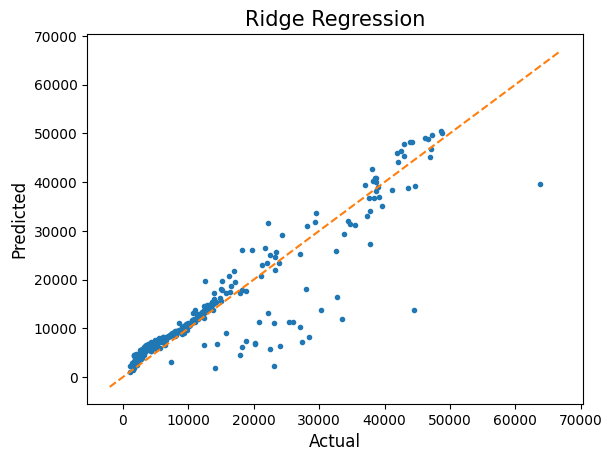

In [ ]:
plotPred(testdata[target], ridge_pred, "Ridge Regression")

# **Random Forest Regression**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFR = Pipeline([
    ('processing', full_pipeline),
    ('model', RandomForestRegressor())
])
RFR.fit(traindata, traindata[target])

Pipeline(steps=[('processing',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures())]),
                                                  ['age', 'bmi', 'children',
                                                   'smoker']),
                                                 ('Class',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=5))]),
                                                  ['sex', 'region'])])),
                ('model', RandomForestRegressor())])

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# data_size = traindata.shape[0]
# n_features = full_pipeline.fit_transform(traindata).shape[1]

param_grid = {
    'model__n_estimators' : [10, 25, 50],
    'model__max_depth' : [2, 6],
    'model__min_samples_split' : [2, 6],
    'model__min_samples_leaf' : [2, 6],
    'model__max_features' : [2, 6],
    'model__max_leaf_nodes' : [2, 6]
}

RFR_grid = HalvingGridSearchCV(RFR, param_grid, cv=5, scoring='r2', return_train_score=True)
RFR_grid.fit(traindata, traindata[target])

HalvingGridSearchCV(estimator=Pipeline(steps=[('processing',
                                               ColumnTransformer(transformers=[('Numeric',
                                                                                Pipeline(steps=[('standardize',
                                                                                                 StandardScaler()),
                                                                                                ('polynomial',
                                                                                                 PolynomialFeatures())]),
                                                                                ['age',
                                                                                 'bmi',
                                                                                 'children',
                                                                                 'smoker']),
                                                                               ('Class',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                               max_categories=5))]),
                                                                                ['sex',
                                                                                 'region'])])),
                                              ('model',
                                               RandomForestRegressor())]),
                    param_grid={'model__max_depth': [2, 6],
                                'model__max_features': [2, 6],
                                'model__max_leaf_nodes': [2, 6],
                                'model__min_samples_leaf': [2, 6],
                                'model__min_samples_split': [2, 6],
                                'model__n_estimators': [10, 25, 50]},
                    scoring='r2')

In [ ]:
measures(RFR, "Non Tuned Random Forest Regression", traindata[target], traindata)

Non Tuned Random Forest Regression 

MAE: 1024.2207924200068
MSE: 3604322.4825699255
r2 Score: 0.9751580901553981



In [ ]:
measures(RFR_grid, "Tuned Random Forest Regression", traindata[target], traindata)

Tuned Random Forest Regression 

MAE: 3178.307556505727
MSE: 24434391.357684765
r2 Score: 0.8315919426880669



## **RFR Test Performance**

In [ ]:
measures(RFR, "Test Non Tuned Random Forest Regression", testdata[target], testdata)

Test Non Tuned Random Forest Regression 

MAE: 2582.79457588816
MSE: 22453602.999227405
r2 Score: 0.8511933633532748



In [ ]:
measures(RFR_grid, "Test Tuned Random Forest Regression", testdata[target], testdata)

Test Tuned Random Forest Regression 

MAE: 3267.0066803104232
MSE: 24298948.760984667
r2 Score: 0.8389637137835894



In [ ]:
RFR_pred = RFR_grid.predict(testdata)

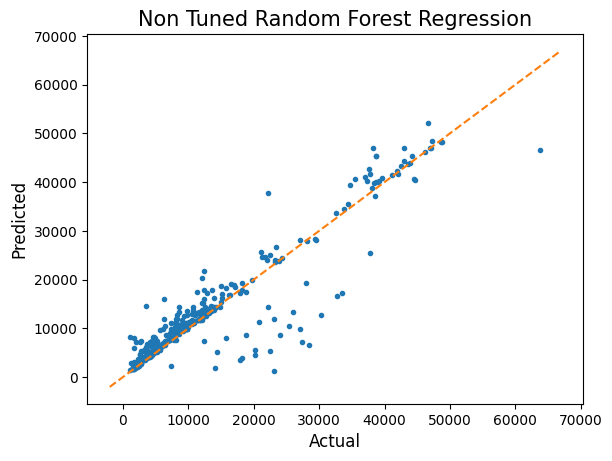

In [ ]:
plotPred(testdata[target], RFR.predict(testdata), "Non Tuned Random Forest Regression")

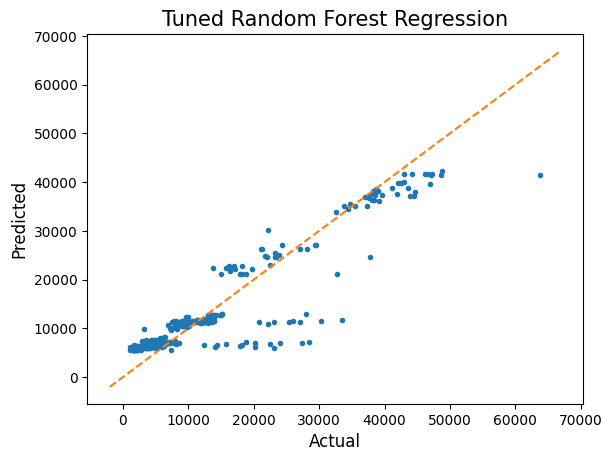

In [ ]:
plotPred(testdata[target], RFR_pred, "Tuned Random Forest Regression")

# **Gradient Boosting Regression**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = Pipeline([
    ('processing', full_pipeline),
    ('model', GradientBoostingRegressor())
])
GBR.fit(traindata, traindata[target])

Pipeline(steps=[('processing',
                 ColumnTransformer(transformers=[('Numeric',
                                                  Pipeline(steps=[('standardize',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures())]),
                                                  ['age', 'bmi', 'children',
                                                   'smoker']),
                                                 ('Class',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 max_categories=5))]),
                                                  ['sex', 'region'])])),
                ('model', GradientBoostingRegressor())])

In [ ]:
param_grid = {
    'model__n_estimators': [10, 25, 50],
    'model__learning_rate': [0.001, 0.01, 0.1, 1.0],
    'model__subsample': [0.5, 0.7, 1.0],
    'model__max_depth': [3, 7, 9]
}
GBR_grid = HalvingGridSearchCV(GBR, param_grid, cv=5, scoring='r2', return_train_score=True)
GBR_grid.fit(traindata, traindata[target])

HalvingGridSearchCV(estimator=Pipeline(steps=[('processing',
                                               ColumnTransformer(transformers=[('Numeric',
                                                                                Pipeline(steps=[('standardize',
                                                                                                 StandardScaler()),
                                                                                                ('polynomial',
                                                                                                 PolynomialFeatures())]),
                                                                                ['age',
                                                                                 'bmi',
                                                                                 'children',
                                                                                 'smoker']),
                                                                               ('Class',
                                                                                Pipeline(steps=[('onehot',
                                                                                                 OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                                               max_categories=5))]),
                                                                                ['sex',
                                                                                 'region'])])),
                                              ('model',
                                               GradientBoostingRegressor())]),
                    param_grid={'model__learning_rate': [0.001, 0.01, 0.1, 1.0],
                                'model__max_depth': [3, 7, 9],
                                'model__n_estimators': [10, 25, 50],
                                'model__subsample': [0.5, 0.7, 1.0]},
                    scoring='r2')

In [ ]:
measures(GBR_grid, "Gradient Boosting Rgeression", traindata[target], traindata)

Gradient Boosting Rgeression 

MAE: 2218.7316326497657
MSE: 15970081.301678302
r2 Score: 0.8899301264451832



## **GBR Test Performance**

In [ ]:
measures(GBR, "Gradient Boosting Rgeression", testdata[target], testdata)

Gradient Boosting Rgeression 

MAE: 2544.318783735751
MSE: 21113072.62148519
r2 Score: 0.8600774527727522



In [ ]:
GBR_pred = GBR_grid.predict(testdata)

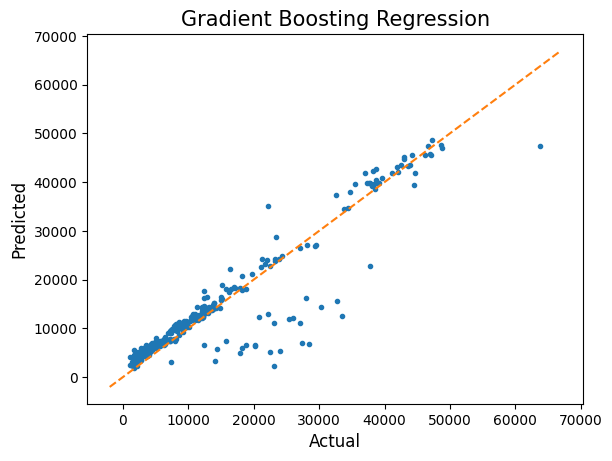

In [ ]:
plotPred(testdata[target], GBR_pred, "Gradient Boosting Regression")

# **Section 3: Measuring Model Performance and Discussion**
---
<br>

In [ ]:
# Plot the MAE

ridge_MAE = mean_absolute_error(testdata[target], ridge_pred)
RFR_MAE = mean_absolute_error(testdata[target], RFR_pred)
GBR_MAE = mean_absolute_error(testdata[target], GBR_pred)

MAE_values = [ridge_MAE, RFR_MAE, GBR_MAE]

In [ ]:
# Plot the MSE

ridge_MSE = mean_squared_error(testdata[target], ridge_pred)
RFR_MSE = mean_squared_error(testdata[target], RFR_pred)
GBR_MSE = mean_squared_error(testdata[target], GBR_pred)

MSE_values = [ridge_MSE, RFR_MSE, GBR_MSE]

In [ ]:
# Plot the r2

ridge_R2 = r2_score(testdata[target], ridge_pred)
RFR_R2 = r2_score(testdata[target], RFR_pred)
GBR_R2 = r2_score(testdata[target], GBR_pred)

R2_values = [ridge_R2, RFR_R2, GBR_R2]

In [ ]:
# Function to expedite the graphing

models = ['Ridge', 'RFR', 'GBR']

def measure_chart(models, values, title):
  fig, ax = plt.subplots(figsize=(12, 4))

  ax.barh(models, values, color=['#5AB4AC', '#ffa65c', '#ea4335'])

  for i, value in enumerate(values):
    ax.text(value + 0.01, i, round(value,2), ha='left', va='center', fontsize=12)

  ax.set_xlabel(title.split()[-2:][0]+" "+title.split()[-2:][-1], fontsize=12)
  ax.set_title(title, fontsize=15)

  plt.tight_layout()
  plt.show()

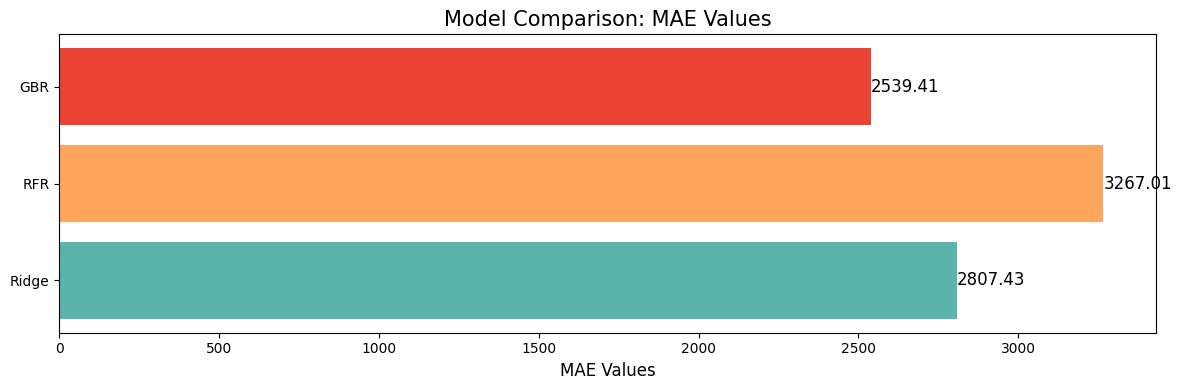

In [ ]:
measure_chart(models, MAE_values, 'Model Comparison: MAE Values')

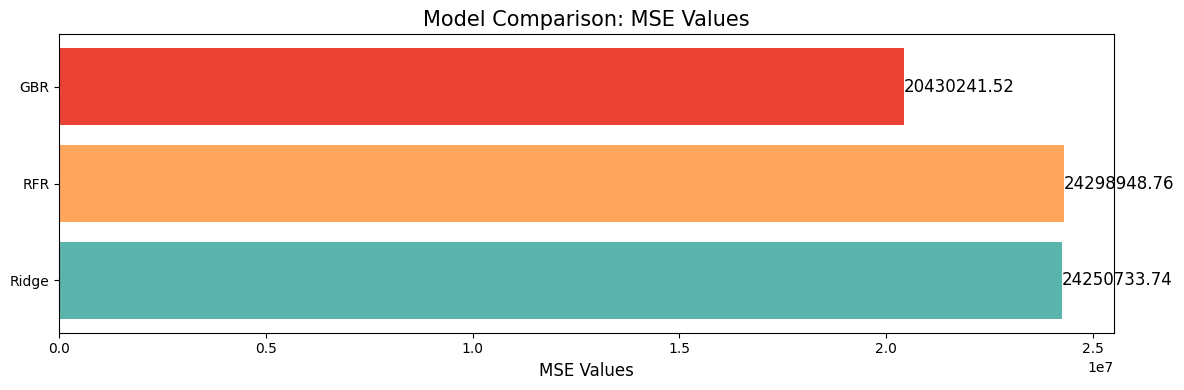

In [ ]:
measure_chart(models, MSE_values, 'Model Comparison: MSE Values')

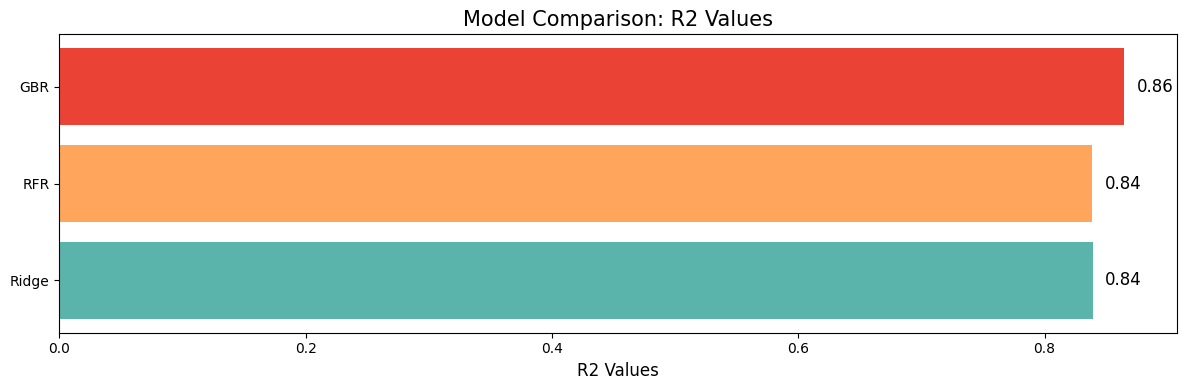

In [ ]:
measure_chart(models, R2_values, 'Model Comparison: R2 Values')

<br>

# **Discussion**
## Gradient boosting regression performed the best of the 3 models. GBR had the highest R2, lowest MAE, and lowest MSE. Ridge and Random Forest performed similarly. Of the 3, RFR had the largest dropoff between train and test R2 performance, indicating overfitting. This was addressed through hyperparamter tuning, but it was not a particularly strong performer.
## Each of the 3 models struggled to predict large "charge" values, but handled low "charge" predictions well. Each of the 3 models tended to under-predict relative to the actual values as can be seen in the Section 2 plots.
## Ultimately GBR was the best performer most likely due to the fact it was able to predict high target values more accurately than the other models.

## In future projects, we would like to completely remove the high end outliers in the "charges" to determine if the models would perform better.